# Digit Recognizer

### Import Dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

import csv

### Preparing Data

In [2]:
data = pd.read_csv('train.csv')
train, test = train_test_split(data, test_size=0.2,random_state=0, stratify=data['label'])
print(train.shape, test.shape)

(33600, 785) (8400, 785)


In [3]:
Y_train = train.loc[:, 'label'].as_matrix()
Y_train = np.eye(10, dtype='float32')[Y_train] 
#it's imp to specify dtype, as default is float64, but placeholder expects float32.
X_train = train.loc[:, train.columns != 'label'].as_matrix()

In [4]:
Y_test = test.loc[:, 'label'].as_matrix()
Y_test = np.eye(10, dtype='float32')[Y_test]
X_test = test.loc[:, test.columns != 'label'].as_matrix()

In [5]:
X_train = np.multiply(X_train, 1.0/255.0)
X_test = np.multiply(X_test, 1.0/255.0)

In [6]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(33600, 784) (33600, 10)
(8400, 784) (8400, 10)


In [7]:
def get_next_batch(initial, batch_size, X, Y):
    return X[initial:initial+batch_size], Y[initial:initial+batch_size]

### Build Computation Graph

#### ANN implementation

In [16]:
def create_placholders():
    X = tf.placeholder(tf.float32, [None, 784], name='X')
    Y = tf.placeholder(tf.int32, [None, 10], name='Y')
    return (X, Y)

In [155]:
def initialize_parameters():

    W1 = tf.get_variable('W1', [784, 128], initializer= tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable('W2', [128, 64], initializer= tf.contrib.layers.xavier_initializer(seed=0))
    W3 = tf.get_variable('W3', [64, 10], initializer= tf.contrib.layers.xavier_initializer(seed=0))
    b1 = tf.get_variable("b1", [128], initializer = tf.zeros_initializer())
    b2 = tf.get_variable("b2", [64], initializer = tf.zeros_initializer())
    b3 = tf.get_variable("b3", [10], initializer = tf.zeros_initializer())
    
    return (W1, W2, W3, b1, b2, b3)

In [24]:
def forward_propogation(X, parameters):
    W1, W2, W3, b1, b2, b3 = parameters
    
    Z1 = tf.matmul(X, W1) + b1
    A1 = tf.nn.relu(Z1, name='A1')

    Z2 = tf.matmul(A1, W2) + b2
    A2 = tf.nn.relu(Z2, name='A2')
    
    Z3 = tf.matmul(A2, W3) + b3
    
    return Z3

In [30]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y), name='cost')
    return cost

In [183]:
def ann_model(X_train, Y_train, X_test, Y_test, learning_rate = 0.01, 
              minibatch_size = 1000):
    X, Y = create_placholders()
    parameters = initialize_parameters()
    Z3 = forward_propogation(X, parameters)
    cost = compute_cost(Z3, Y)
    adam_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    costs = []
    initial = 0
    
    with tf.Session() as sess:
        sess.run(init)
        for i in range(3001):
            batch_xs, batch_ys = get_next_batch(initial, minibatch_size, X_train, Y_train)
            initial = 0 if initial>=33000 else initial + minibatch_size
            _, c = sess.run([adam_optimizer, cost], feed_dict={X: batch_xs,
                                                              Y: batch_ys})
            if (i%500==0):
                print('Iteration:', i, 'Cost', c)
            if (i%10==0):
                costs.append(c)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.show()
        
        parameters = sess.run(parameters)
    return parameters

In [165]:
def get_accuracy(X_, Y_, parameters):
    X = tf.placeholder("float", [X_.shape[0], 784])
    Z3 = forward_propogation(X, parameters)
    correct_prediction = tf.equal(tf.argmax(Y_, 1), tf.argmax(Z3, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    with tf.Session() as sess:
        accuracy = sess.run(accuracy, feed_dict={X: X_})
    return accuracy

In [166]:
def predict(X, parameters):    
    x = tf.placeholder("float", [X.shape[0], 784])
    z3 = forward_propogation(x, parameters)
    p = tf.argmax(z3, 1)
    with tf.Session() as sess:
        prediction = sess.run(p, feed_dict = {x: X})
    return prediction

### Training the model

Iteration: 0 Cost 2.36598
Iteration: 500 Cost 0.263637
Iteration: 1000 Cost 0.192011
Iteration: 1500 Cost 0.13292
Iteration: 2000 Cost 0.148404
Iteration: 2500 Cost 0.0974675
Iteration: 3000 Cost 0.0813642
Iteration: 3500 Cost 0.0622542
Iteration: 4000 Cost 0.0608119
Iteration: 4500 Cost 0.0410154
Iteration: 5000 Cost 0.0288071
Iteration: 5500 Cost 0.0233924
Iteration: 6000 Cost 0.0239843
Iteration: 6500 Cost 0.0166787
Iteration: 7000 Cost 0.0170415
Iteration: 7500 Cost 0.0126487
Iteration: 8000 Cost 0.0142802
Iteration: 8500 Cost 0.00829819
Iteration: 9000 Cost 0.00599018
Iteration: 9500 Cost 0.00455567
Iteration: 10000 Cost 0.00398497


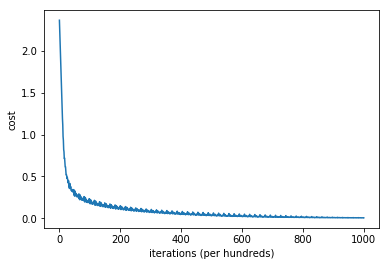

CPU times: user 7min 27s, sys: 24.4 s, total: 7min 51s
Wall time: 1min 5s


In [182]:
%%time
tf.reset_default_graph()
learning_rate = 0.0001
parameters = ann_model(X_train, Y_train, X_test, Y_test, learning_rate=learning_rate)

### Accuracy calculation

In [184]:
print('Train Accuracy', get_accuracy(X_train, Y_train, parameters))
print('Test Accuracy', get_accuracy(X_test, Y_test, parameters))

Train Accuracy 0.99994
Test Accuracy 0.967738


### Prediction on kaggle test data set

In [46]:
X_test_data = pd.read_csv('test.csv').as_matrix()
X_test_data = np.multiply(X_test_data, 1.0/255.0)
print(X_test_data.shape)

(28000, 784)


In [185]:
Y_predicted = predict(X_test_data, parameters)
with open('submission-v1.csv', 'w') as file:
    writer = csv.writer(file)
    writer.writerow(['ImageId', 'Label'])
    for i in range(Y_predicted.shape[0]):
        writer.writerow([i+1, Y_predicted[i]])

#### For tensorboard visualization

In [56]:
# writer = tf.summary.FileWriter("output", sess.graph)
# writer.close()

NameError: name 'sess' is not defined

In [170]:
#before changing any node in the graph, reset the default graph, run new nodes, reinitialize the session and variables.
# to retrain the model, just re-initialise the variables by sess.run(init)
# sess.close ? what it actually does?
# sess.close()
tf.reset_default_graph() # new default graph is created. 

In [171]:
with tf.Session() as sess:
    print(sess.run(tf.report_uninitialized_variables()))

[]
